In [19]:
import plot
from shap.maskers import Independent
from sklearn.utils import resample
import shap
from matplotlib import pyplot as plt
from sklearn.utils import resample, shuffle
import numpy as np
import pandas as pd
import pickle
%matplotlib inline
shap.initjs()

In [2]:
with open('dataset.pickle', 'rb') as f:
    X, y, display_data, feature_names, n_features, n_samples = pickle.load(f)
with open('classifiers.pickle', 'rb') as f:
    clf_a, clf_b = pickle.load(f)
with open('predictions.pickle', 'rb') as f:
    indices, pred_a, pred_b, proba_a, proba_b, log_proba_a, log_proba_b, log_odds_a, log_odds_b = pickle.load(f)
with open('subsets.pickle', 'rb') as f:
    is_pred_diff, is_pred_diff_a_pos, is_pred_diff_b_pos, proba_diff_a_pos, proba_diff_b_pos, proba_diff, log_odds_diff_a_pos, log_odds_diff_b_pos, log_odds_diff = pickle.load(f)

In [6]:
try:
    with open('shapvalues.proba.pickle', 'rb') as f:
        shap_values_diff, shap_values_diff_a_pos, shap_values_diff_b_pos, overall_importance, feature_order, shap_values_diff_a_vs_b_pos = pickle.load(f)
        print('Loaded cached shap values')
except FileNotFoundError:
    print('No cached shap values found')

Loaded cached shap values


Now we define the difference functions to be explained:

In [3]:
merge_proba_diff_c1_pos = lambda p1, p2: p1[:, 1] * p2[:, 0]
predict_proba_diff_a_pos = lambda X: merge_proba_diff_c1_pos(clf_a.predict_proba(X), clf_b.predict_proba(X))
predict_proba_diff_b_pos = lambda X: merge_proba_diff_c1_pos(clf_b.predict_proba(X), clf_a.predict_proba(X))

In [4]:
merge_proba_diff = lambda p1, p2: merge_proba_diff_c1_pos(p1, p2) + merge_proba_diff_c1_pos(p2, p1)
predict_proba_diff = lambda X: merge_proba_diff(clf_a.predict_proba(X), clf_b.predict_proba(X))

And now we calculate SHAP values for each merge function:

In [5]:
%%time

background_data = X
def explain(predict):
    masker = Independent(data=background_data, max_samples=100)
    explainer = shap.Explainer(predict, masker, feature_names=feature_names)
    shap_values = explainer(X)
    shap_values.display_data = display_data
    return shap_values

shap_values_diff_a_pos = explain(predict_proba_diff_a_pos)
shap_values_diff_b_pos = explain(predict_proba_diff_b_pos)

shap_values_diff = shap_values_diff_a_pos + shap_values_diff_b_pos
shap_values_diff.data = shap_values_diff_a_pos.data
shap_values_diff.display_data = shap_values_diff_a_pos.display_data

overall_importance = shap_values_diff.abs.mean(axis=0)
feature_order = np.flip(overall_importance.values.argsort())

shap_values_diff_a_vs_b_pos = shap_values_diff_b_pos - shap_values_diff_a_pos
shap_values_diff_a_vs_b_pos.data = shap_values_diff_a_pos.data
shap_values_diff_a_vs_b_pos.display_data = shap_values_diff_a_pos.display_data

with open(f'shapvalues.proba.pickle', 'wb') as f:
    pickle.dump((shap_values_diff, shap_values_diff_a_pos, shap_values_diff_b_pos, overall_importance, feature_order, shap_values_diff_a_vs_b_pos), f, pickle.HIGHEST_PROTOCOL)

Permutation explainer: 32562it [30:03, 17.99it/s]                            
Permutation explainer: 32562it [30:40, 17.57it/s]                            


CPU times: user 1h 31min 19s, sys: 8min 14s, total: 1h 39min 34s
Wall time: 1h 50s


## Analyze

### Feature Importance

We estimate it with the mean absolute SHAP value (which is the default for this plot) and will also sort features subsequently in this order

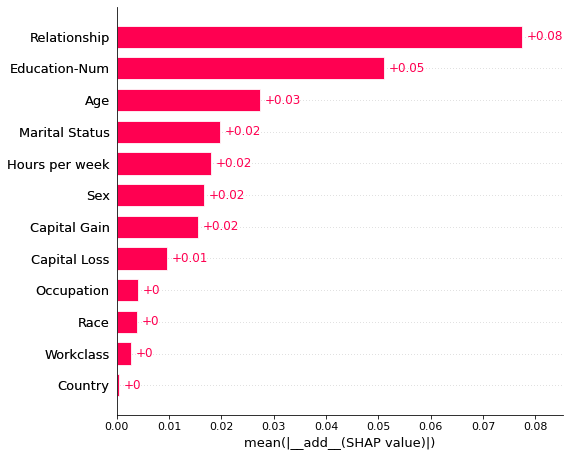

In [6]:
shap.plots.bar(overall_importance, max_display=n_features)

We see, that compared to the overall importance in the lower segment both Relationship and Education-Num are more important while in the higher difference probability segment these probabilities decrease and decrease even further for the actual different subset

There is actually a significant difference in the two error classes: Capital Gain is more important for B to predict the positive label than for A to predict the positive label

But we cannot confirm this completely by looking at the importance differences of the separate difference models 

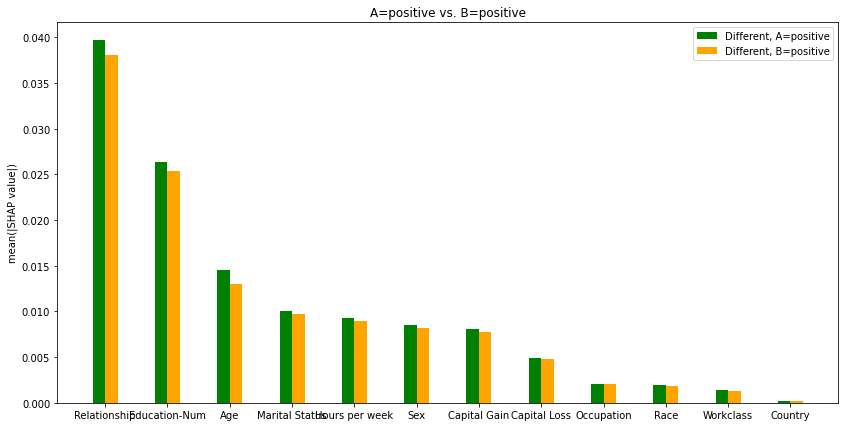

In [7]:
x = np.arange(n_features)
width = 0.2
fig, ax = plt.subplots(figsize=(14, 7))
rects1 = ax.bar(x - width/2, shap_values_diff_a_pos.abs.mean(0)[feature_order].values, width, label='Different, A=positive', color='green')
rects2 = ax.bar(x + width/2, shap_values_diff_b_pos.abs.mean(0)[feature_order].values, width, label='Different, B=positive', color='orange')
ax.set_ylabel('mean(|SHAP value|)')
ax.set_title('A=positive vs. B=positive')
ax.set_xticks(x)
ax.set_xticklabels(feature_names[feature_order])
ax.legend()
plt.show()

### SHAP Value Distribution

Next, we will try to understand the importances using the whole distribution of values, not only the aggregated mean.

TODO: build own plots, where all sets of instances are in one plot, with different colors per set and a color range from low to high feature value as well

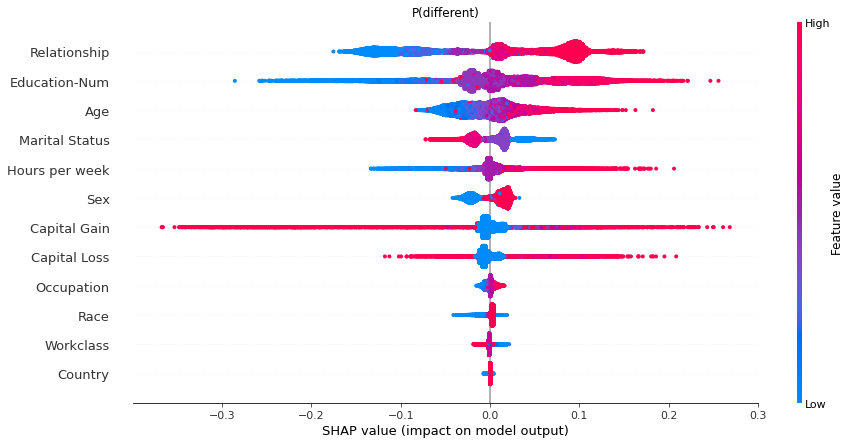

In [8]:
plot.shap_beeswarm(shap_values_diff, 'P(different)', order=feature_order, max_display=n_features)

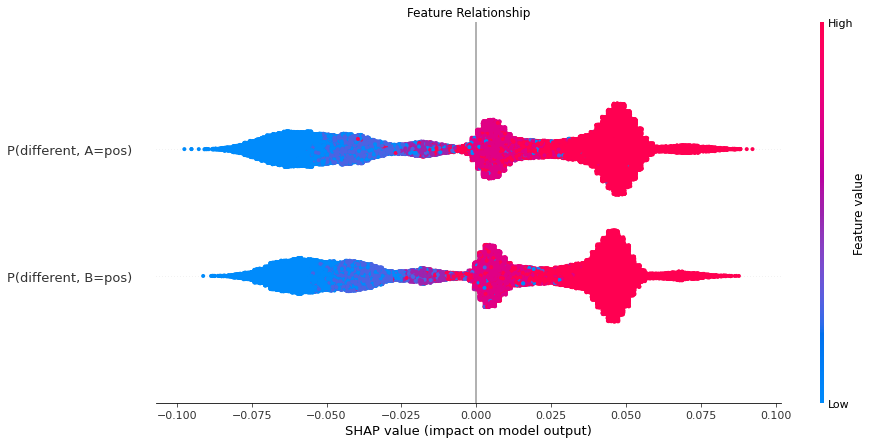

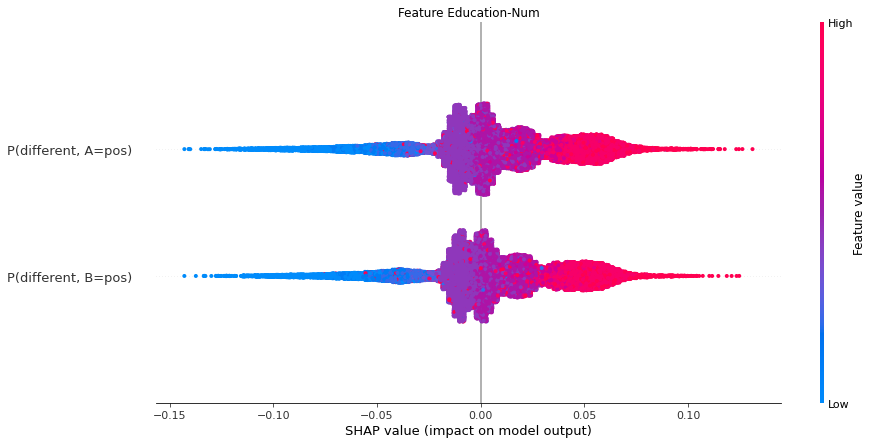

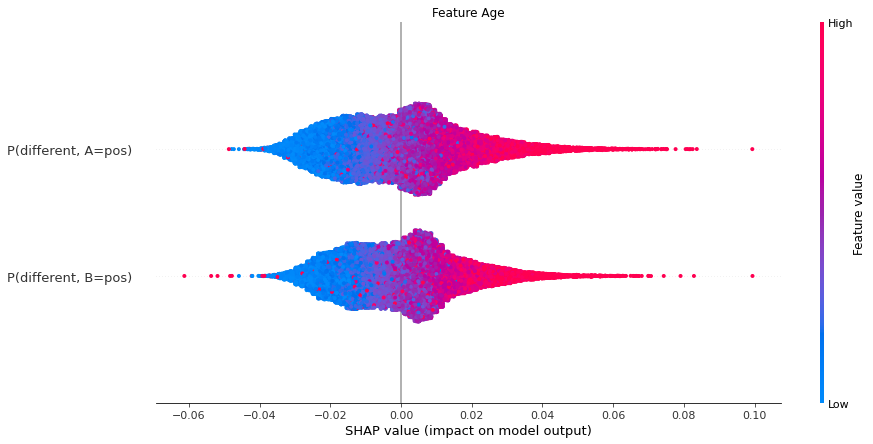

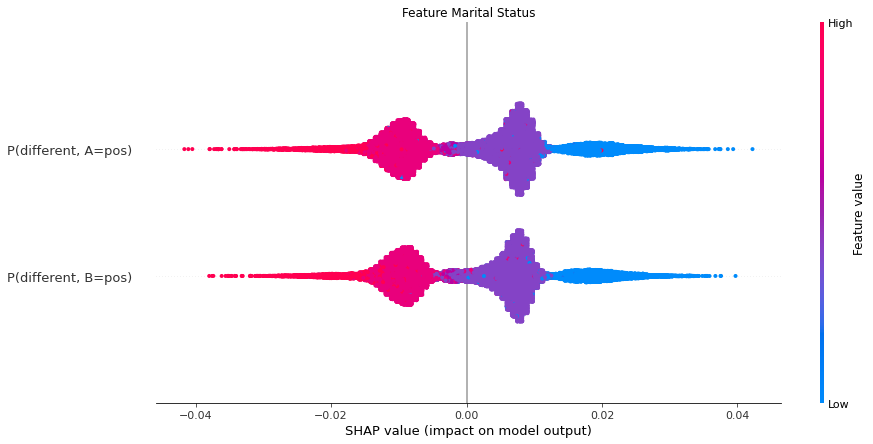

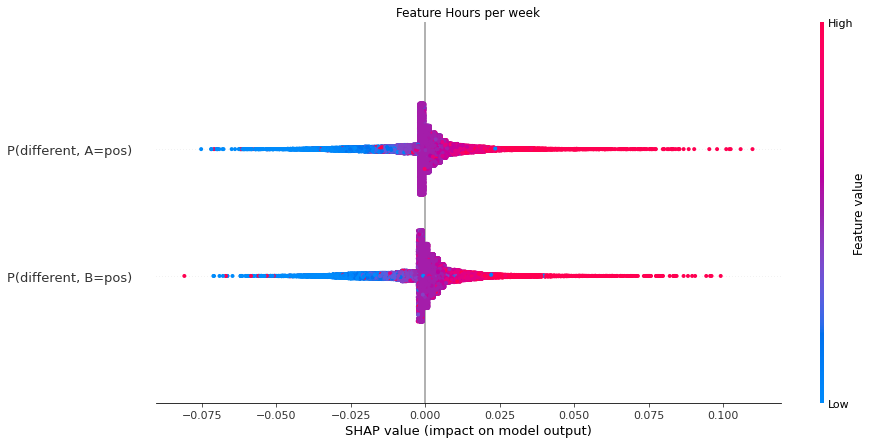

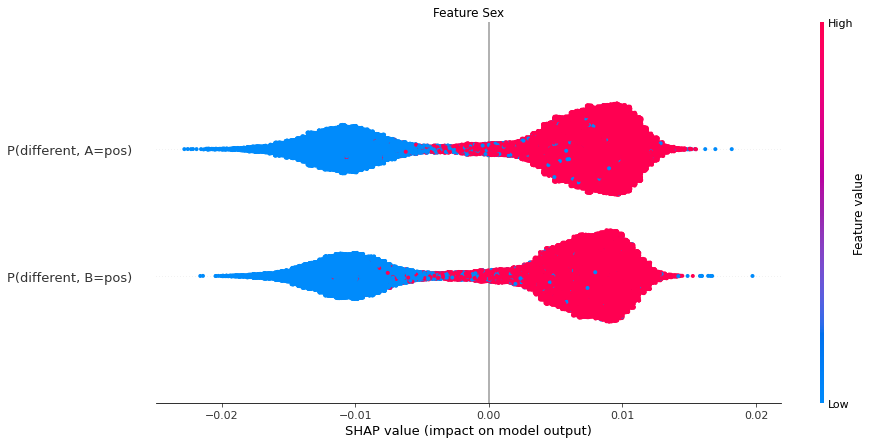

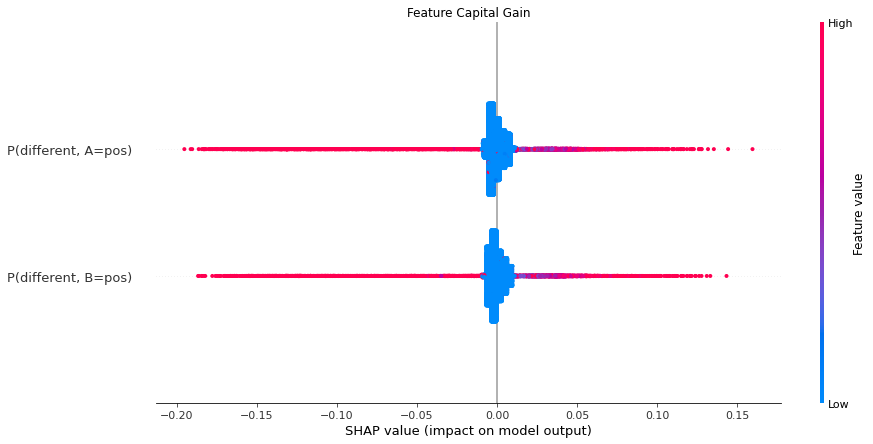

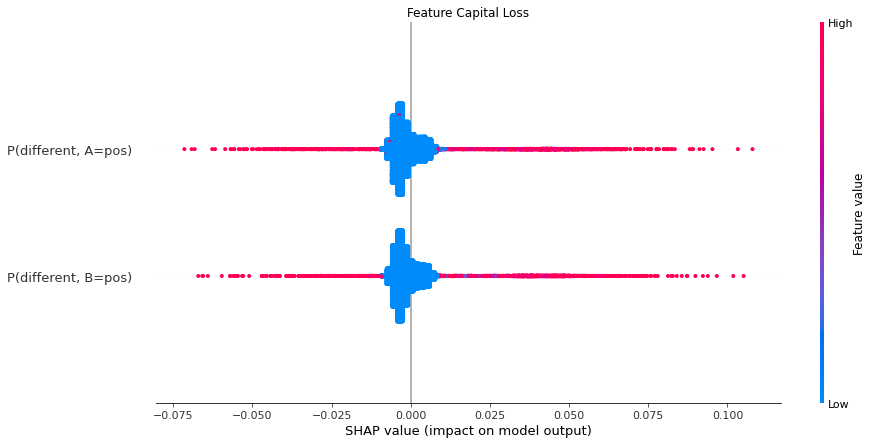

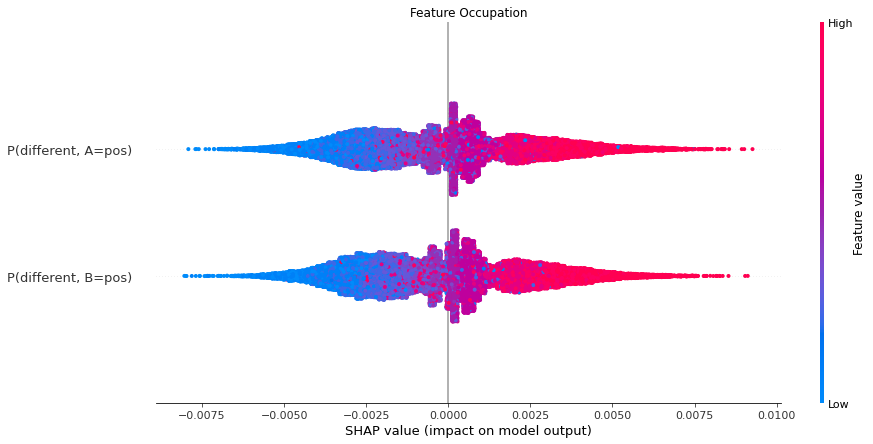

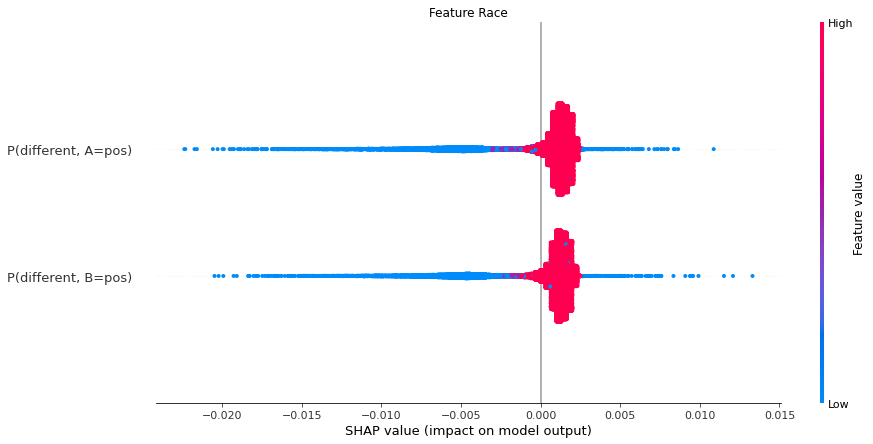

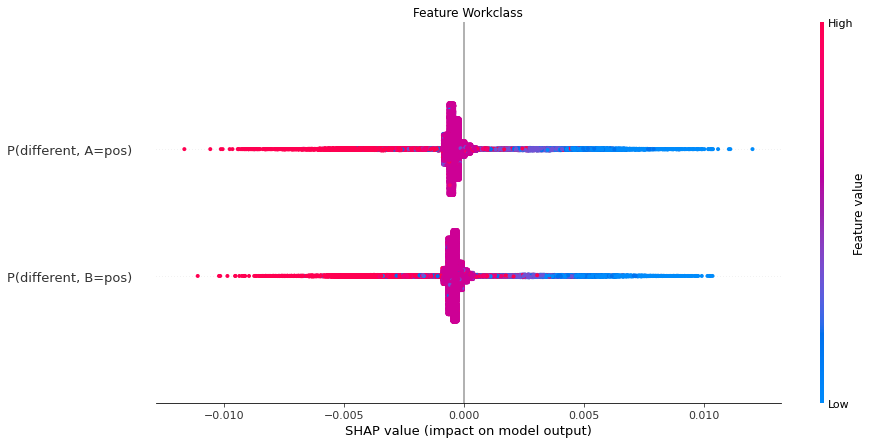

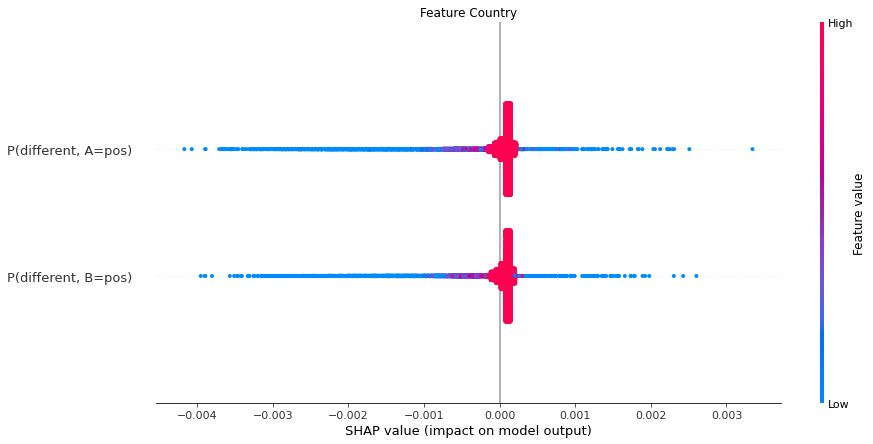

In [12]:
for feature in feature_names[feature_order]:
    a_feature = shap_values_diff_a_pos[:, feature]
    b_feature = shap_values_diff_b_pos[:, feature]
    values = np.array([a_feature.values, b_feature.values]).T
    base_values = np.array([a_feature.base_values, b_feature.base_values]).T
    data = np.array([a_feature.data, b_feature.data]).T
    display_data = np.array([a_feature.display_data, b_feature.display_data]).T
    explanation = shap.Explanation(values, base_values, data, display_data, feature_names=['P(different, A=pos)', 'P(different, B=pos)'])
    plot.shap_beeswarm(explanation, 'Feature ' + feature)

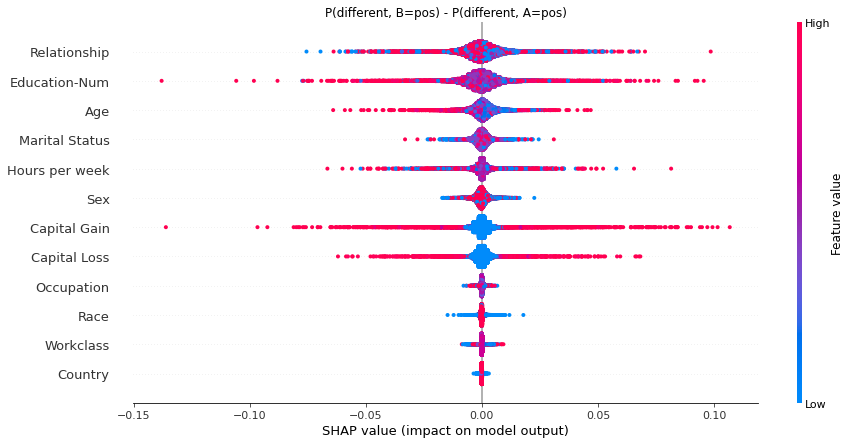

In [11]:
plot.shap_beeswarm(shap_values_diff_a_vs_b_pos, 'P(different, B=pos) - P(different, A=pos)', order=feature_order, max_display=n_features)

### Features' Partial Dependence Plots

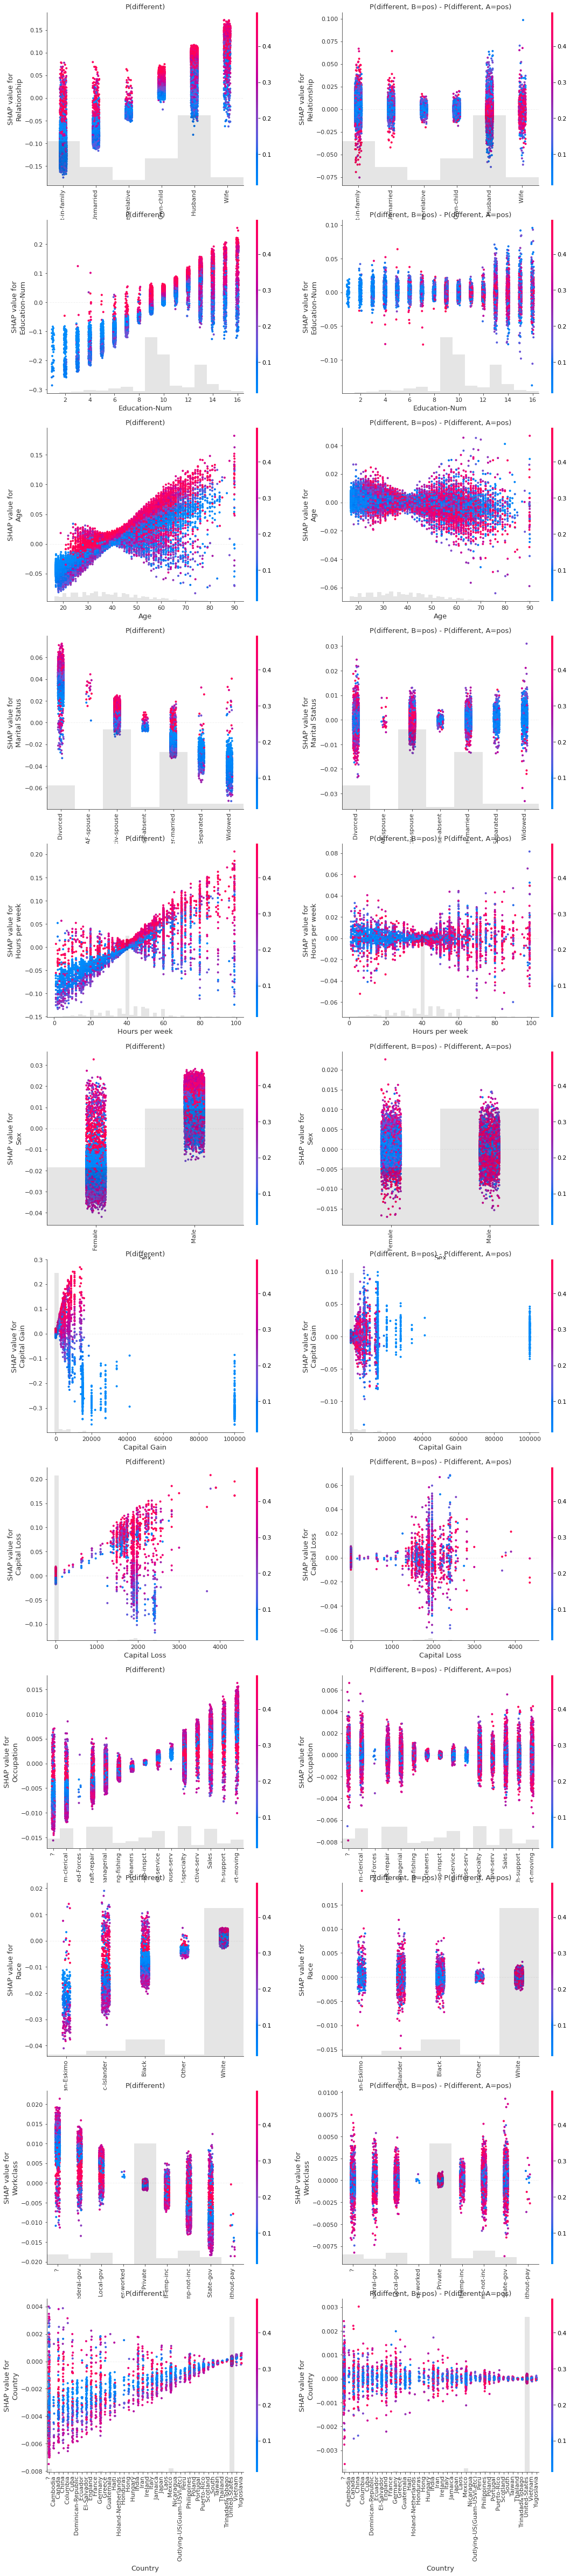

In [16]:
n_columns = 2
n_rows = n_features
fig = plt.figure(figsize=(9*n_columns, 7*n_rows))
i = 1
for feature in feature_names[feature_order]:
    ax1 = fig.add_subplot(n_rows, n_columns, i)
    ax2 = fig.add_subplot(n_rows, n_columns, i+1, sharey=None)
    shap.plots.scatter(shap_values_diff[:, feature], title='P(different)', ax=ax1, color=proba_diff, show=False)
    shap.plots.scatter(shap_values_diff_a_vs_b_pos[:, feature], title='P(different, B=pos) - P(different, A=pos)', ax=ax2, color=proba_diff, show=False)
    i += n_columns
plt.show()

### Stacked SHAP Explanations, Clustered by Similarity

In [17]:
mask = pred_a != pred_b
order = plot.shap_force(shap_values_diff[mask], 'P(different)')
plot.shap_force(shap_values_diff_a_pos[mask], 'P(different, A=pos)', ordering=order)
plot.shap_force(shap_values_diff_b_pos[mask], 'P(different, B=pos)', ordering=order);

In [18]:
idx_pred_eq = resample(indices[pred_a == pred_b], n_samples=100, replace=False, random_state=2)
order = plot.shap_force(shap_values_diff[idx_pred_eq], 'P(different)')
plot.shap_force(shap_values_diff_a_pos[idx_pred_eq], 'P(different, A=pos)', ordering=order)
plot.shap_force(shap_values_diff_b_pos[idx_pred_eq], 'P(different, B=pos)', ordering=order);

### Hierarchically Clustered SHAP Values

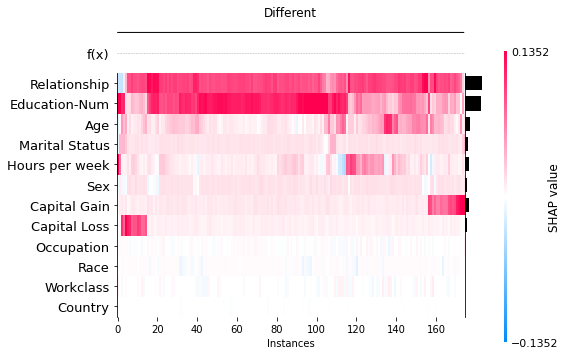

In [22]:
plot.shap_heatmap(shap_values_diff[pred_a != pred_b], 'Different', feature_order)

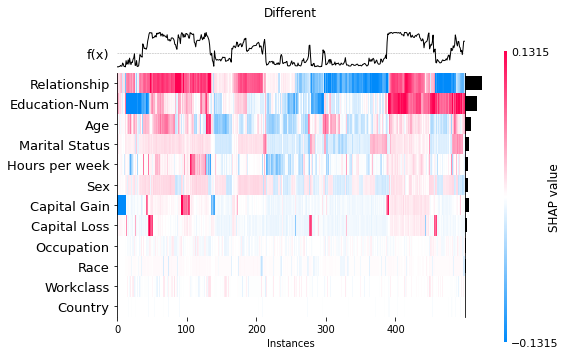

In [23]:
idx = shuffle(indices[pred_a == pred_b], random_state=0, n_samples=500)
plot.shap_heatmap(shap_values_diff[idx], 'Different', feature_order)

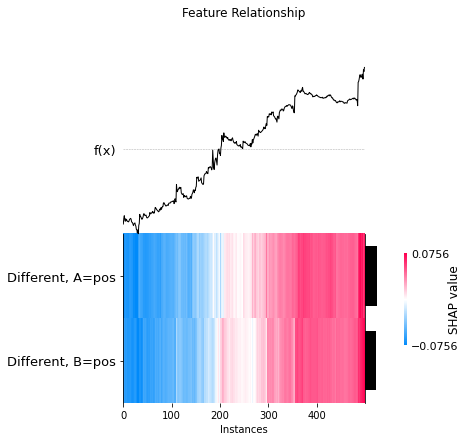

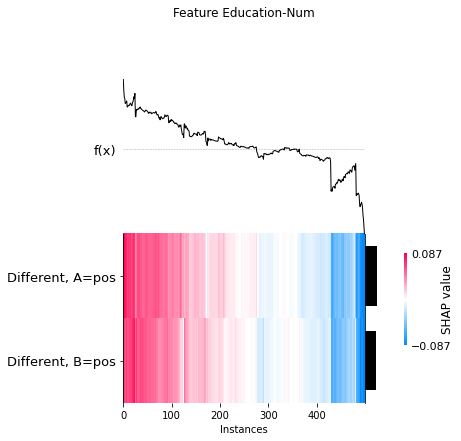

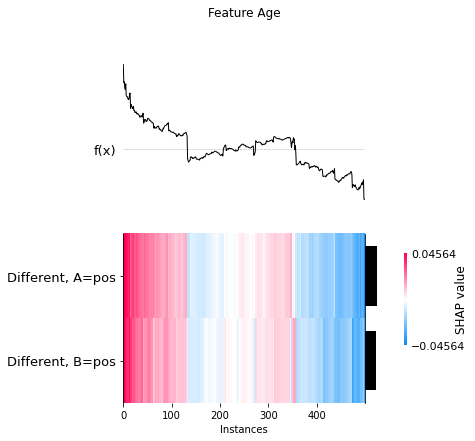

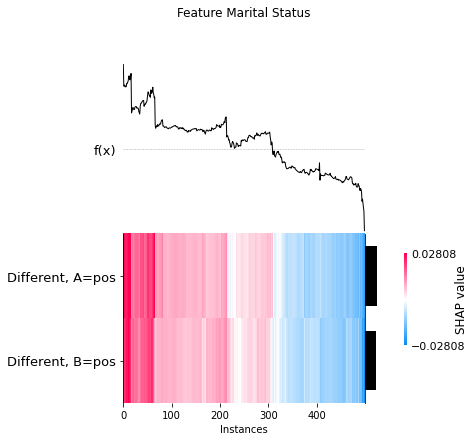

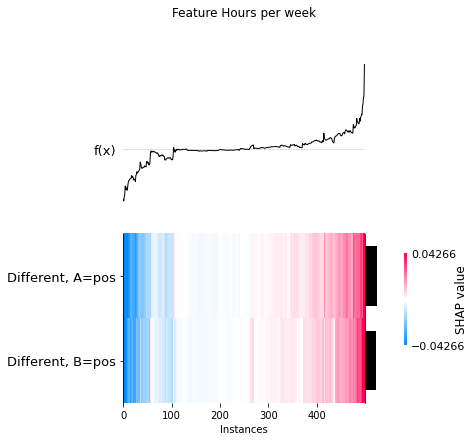

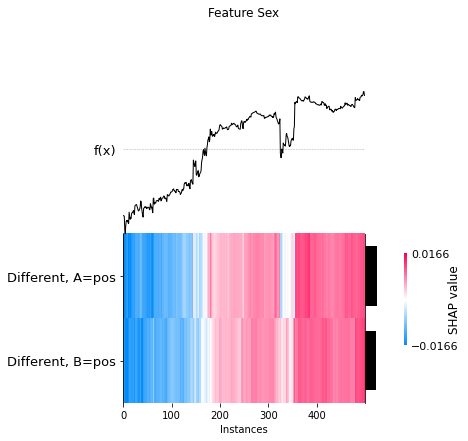

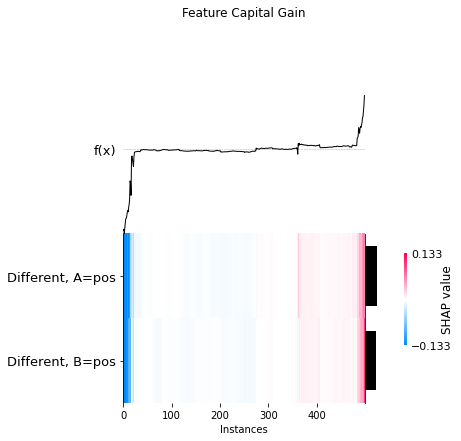

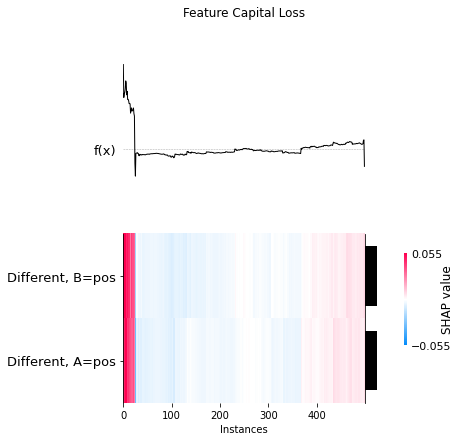

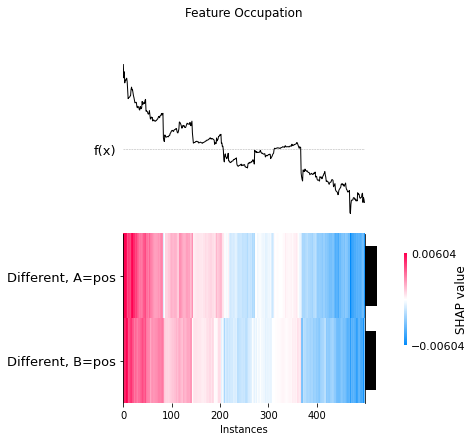

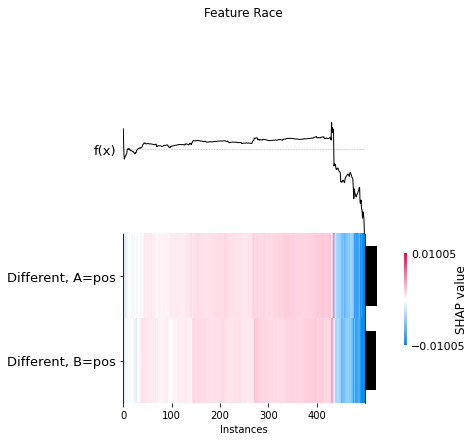

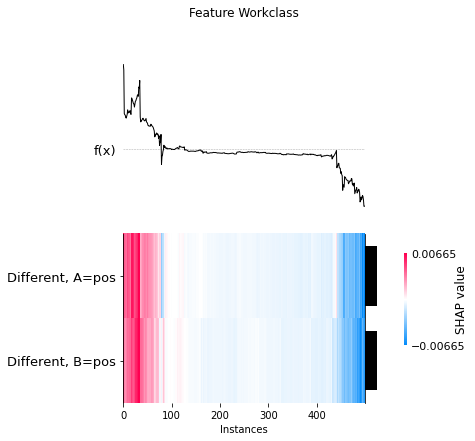

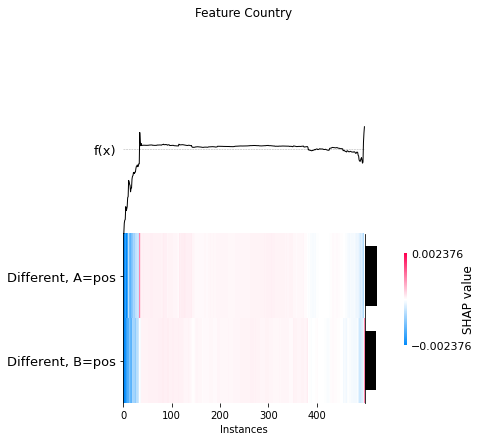

In [26]:
idx = shuffle(indices, random_state=0, n_samples=500)
for feature in feature_names[feature_order]:
    a_feature = shap_values_diff_a_pos[idx, feature]
    b_feature = shap_values_diff_b_pos[idx, feature]
    values = np.array([a_feature.values, b_feature.values]).T
    base_values = np.array([a_feature.base_values, b_feature.base_values]).T
    data = np.array([a_feature.data, b_feature.data]).T
    dspl_data = np.array([a_feature.display_data, b_feature.display_data]).T
    explanation = shap.Explanation(values, base_values, data, dspl_data, feature_names=['Different, A=pos', 'Different, B=pos'])
    plot.shap_heatmap(explanation, 'Feature ' + feature)